# Technical Fantasy Footall Analysis

This is my jupiter notebook with a fantasy football analysis of week to week data for nfl players, resulting in a 0-100 weekly player rating at the end of the analysis.

# How to run:
Simply select run all and view the outputs of each individual cell or run each cell individually in sequential order as the imports from the first few cells are used throughout.

# Loading and profiling the data:
This is done to give a quick overview of the csv file and the different data within; listing traits such as NaN values, unique values and data types.

In [69]:
import numpy as np
import pandas as pd

# Loading in the data
df = pd.read_csv("weekly_ss_scaled.csv")

# Profile the data
def data_profile(df):
    profile = pd.DataFrame({
        'dtype': df.dtypes,
        'NaN%': df.isna().mean() * 100,
        'unique_values': [df[col].nunique() for col in df.columns]
    })
    return profile

# Set pandas to show all rows
pd.set_option('display.max_rows', None)

profile = data_profile(df)
print(profile)

                                       dtype  NaN%  unique_values
Unnamed: 0                             int64   0.0           7109
title                                 object   0.0            268
event_id                              object   0.0            268
player_name                           object   0.0            611
team_abbreviation                     object   0.0             32
is_motion                              int64   0.0             27
motion_at_snap                         int64   0.0             21
pre_snap_motion                        int64   0.0             22
rushing_attempt                        int64   0.0             35
rushing_touchdown                      int64   0.0              4
rushing_yards                          int64   0.0            167
yards_after_contact                    int64   0.0            120
yards_after_catch                      int64   0.0            105
dropped_pass                           int64   0.0              3
receiving_

# Cleaning the data
- dropped duplicate rows
- coerced oject types that needed to be treated as numerics into numerics
- capilitized team codes
- stripped the index column (not necessary in this analyis)
- converted empty values (--) to NaN values

Lastly I ran a profile of the data frame again to make sure that the data was properly cleaned.

In [70]:
def clean_data(df):
    """
    Clean the data based on the objectives above

    parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to clean

    Returns:
    --------
    pandas.DataFrame
        Cleaned DataFrame
    """
    df_clean = df.copy()

    if 'Unnamed: 0' in df_clean.columns:
        df_clean = df_clean.drop('Unnamed: 0', axis=1)
    
    df_clean = df_clean.drop_duplicates()

    if 'event_id' in df_clean.columns:
        df_clean['event_id'] = df_clean['event_id'].str.upper()

    df_clean = df_clean.replace('--', np.nan)

    # logic to drop rows that have all 0 numeric values
    numeric_cols = df_clean.select_dtypes(include=['number']).columns

    if len(numeric_cols) > 0:
        all_numeric_are_zero = (df_clean[numeric_cols] == 0).all(axis=1)
        df_clean = df_clean[~all_numeric_are_zero]

    # logic to drop duplicate columns with different names
    df_transposed = df_clean.T
    is_duplicate_column = df_transposed.duplicated(keep='first')
    columns_to_drop = df_transposed[is_duplicate_column].index.tolist()

    df_clean = df_clean.drop(columns=columns_to_drop)

    # logic to coerce numerics that need to be coerced
    df_result = df_clean.copy()

    object_columns = df_clean.select_dtypes(include=['object']).columns

    for col in object_columns:
        sample = df_clean[col].dropna()

        if len(sample) == 0:
            continue 
        
        numeric_count = 0
        total_count = len(sample)

        for val in sample:
            test_val = str(val).replace(',', '').replace('%', '').strip()

            if test_val.replace('.', '', 1).replace('-', '', 1).isdigit():
                numeric_count += 1

        numeric_percentage = (numeric_count / total_count) * 100

        if numeric_percentage > 95:
            try:
                original_nan_count = df[col].isna().sum()
                df_result[col] = pd.to_numeric(df_clean[col], errors='coerce')
                new_nan_count = df_result[col].isna().sum()

                if new_nan_count - original_nan_count > 0.1 * len(df_clean):
                    df_result[col] = df_clean[col]
            except:
                pass

    df_clean = df_result
        
    return df_clean

df_clean = clean_data(df)

clean_profile = data_profile(df_clean)
print(clean_profile)

                                       dtype  NaN%  unique_values
title                                 object   0.0            268
event_id                              object   0.0            268
player_name                           object   0.0            604
team_abbreviation                     object   0.0             32
is_motion                              int64   0.0             27
motion_at_snap                         int64   0.0             21
pre_snap_motion                        int64   0.0             22
rushing_attempt                        int64   0.0             35
rushing_touchdown                      int64   0.0              4
rushing_yards                          int64   0.0            167
yards_after_contact                    int64   0.0            120
yards_after_catch                      int64   0.0            105
dropped_pass                           int64   0.0              3
receiving_targets                      int64   0.0             21
receiving_

# Util methods to be used for my analysis and commentary:

In [ ]:
def get_player_stats(df, player_name, stat_column=None):
    """
    Retrieve statistics for a specific player.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The NFL player stats DataFrame
    player_name : str
        Name of the player to search for (case-insensitive partial match)
    stat_column : str or list, optional
        Specific stat column(s) to return. If None, returns all columns for said player.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the player's statistics
    """
    player_mask = df['player_name'].str.contains(player_name, case=False)
    player_data = df[player_mask]

    if len(player_data) == 0:
        print(f"No player found matching '{player_name}'")
        #show closest matches as a suggestion
        all_players = df['player_name'].unique()
        closest_matches = [p for p in all_players if player_name.lower() in p.lower()]
        if closest_matches:
            print(f"Did you mean one of these players? {', '.join(closest_matches[:5])}")
        return None
    
    #Logic for retrieving a specific stat
    if stat_column:
        if isinstance(stat_column, str):
            if stat_column in player_data.columns:
                return player_data[['player_name', 'title', stat_column]]
            else:
                print(f"Column '{stat_column}' not found. Available columns: {', '.join(player_data.columns[:10])}...")
                return None
        elif isinstance(stat_column, list):
            columns_to_return = ['player_name', 'title', 'team_abbreviation', 'position'] + [col for col in stat_column]
            return player_data[columns_to_return]

    return player_data

def get_max_stats(df, stats, positions=None):
    """
    Find the player(s) with the maximum value for each statistic and position combination.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing player statistics
    stats : str or list
        Either a single statistic (string) or a list of statistics
    positions : str or list, optional
        Either a single position (string) or a list of positions.
        If None, uses all positions in the dataset.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame showing the player with max stat value for each position and statistic
    """
    filtered_df = df.copy()
    
    if 'position' not in filtered_df.columns:
        print("Error: Position column not found in the dataset")
        return None
        
    # Process positions parameter
    if positions is None:
        position_list = sorted(filtered_df['position'].unique())

    elif isinstance(positions, str):
        position_list = [positions]

    else:
        position_list = list(positions)
    
    # Process stats parameter
    if isinstance(stats, str):
        stat_list = [stats]

    else:
        stat_list = list(stats)
    
    missing_stats = [stat for stat in stat_list if stat not in filtered_df.columns]
    if missing_stats:
        print(f"Warning: These statistics were not found in the dataset: {', '.join(missing_stats)}")

        stat_list = [stat for stat in stat_list if stat in filtered_df.columns]
        
        if not stat_list:
            print("Error: No valid statistics to process")
            return None
    
    all_results = pd.DataFrame()
    
    # Process each position and statistic combination
    for pos in position_list:
        pos_data = filtered_df[filtered_df['position'] == pos]
            
        for stat in stat_list:
            max_value = pos_data[stat].max()
            
            # Skip if all values are NaN
            if pd.isna(max_value):
                continue
            
            # Find all players who achieved this maximum
            max_players = pos_data[pos_data[stat] == max_value]
            
            all_results = pd.concat([all_results, max_players])

    columns_to_return = ['player_name', 'title', 'team_abbreviation', 'position'] + [col for col in stat_list]
    return all_results[columns_to_return]


# Initial data vizualizations:
# vizualization #1: Boxplot of rushing yards by position

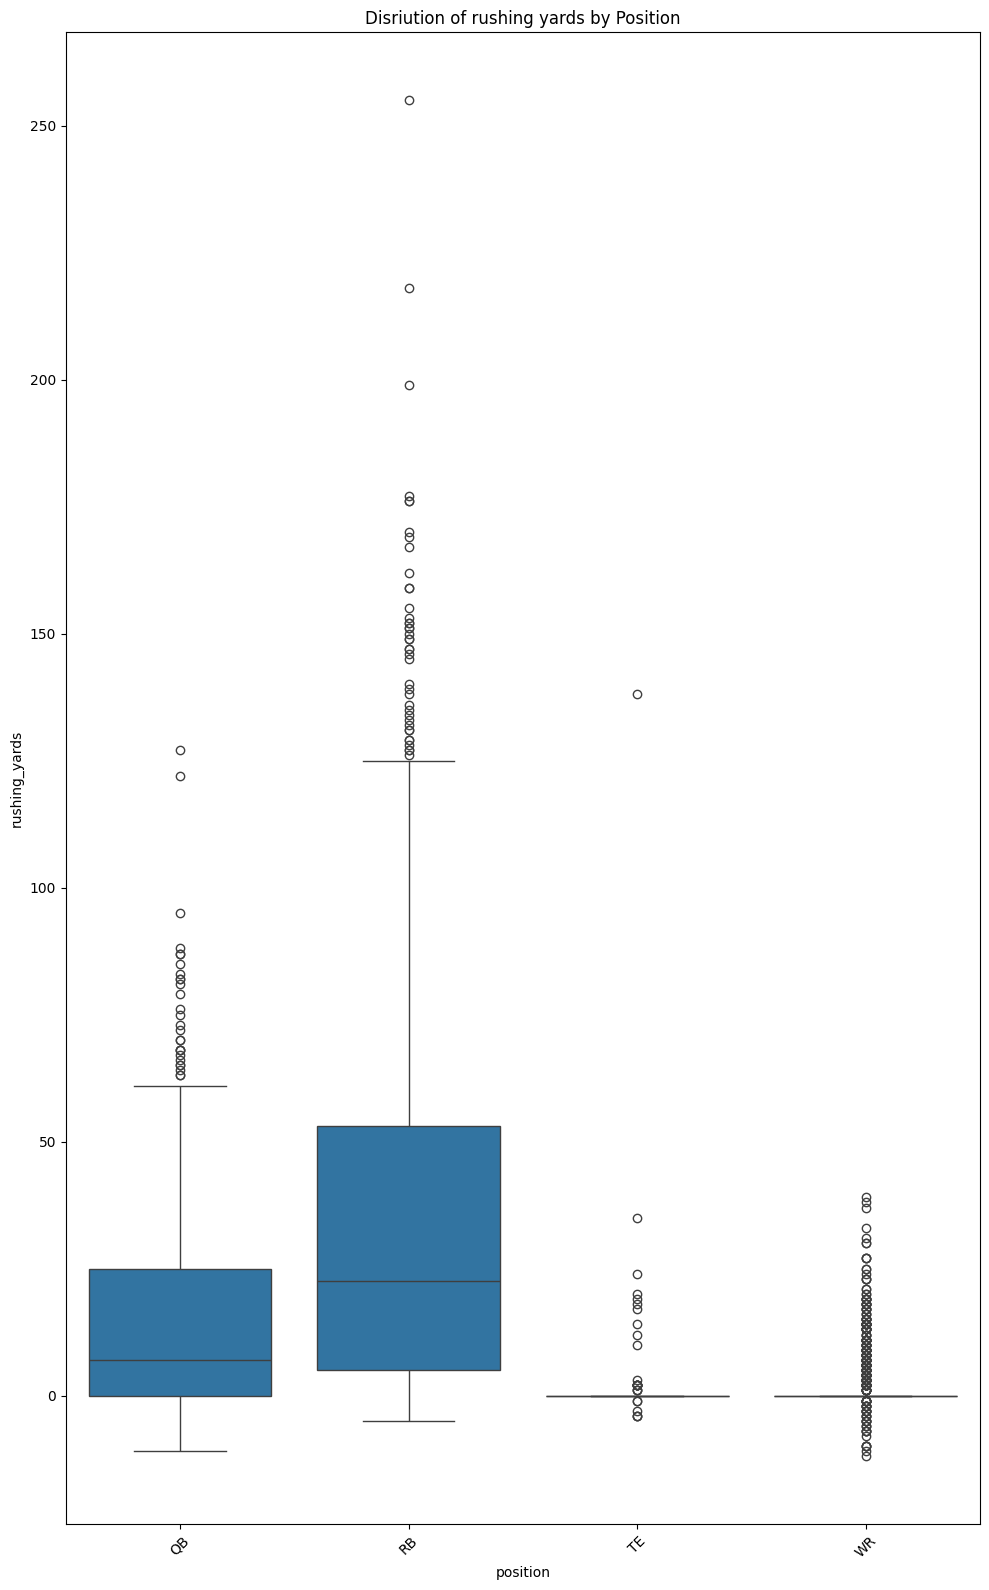

,player_name,title,team_abbreviation,position,rushing_yards
2968,Jayden Daniels,ATL @ WAS,WAS,QB,127
1159,Taysom Hill,CLE @ NO,NO,TE,138
3922,Saquon Barkley,PHI @ LA,PHI,RB,255


,player_name,title,team_abbreviation,position,rushing_yards
6575,Lamar Jackson,BAL @ KC,BAL,QB,122


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.figure(figsize=(10,16))
sns.boxplot(x='position', y='rushing_yards', data=df_clean)
plt.title('Disriution of rushing yards by Position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
display(get_max_stats(df_clean, 'rushing_yards', ['QB', 'TE', 'RB']))
lamar_df = get_player_stats(df_clean, 'lamar jackson',['rushing_yards'])
lamar_max_idx = lamar_df['rushing_yards'].idxmax()
lamar_max_rushing = lamar_df.loc[[lamar_max_idx]]
display(lamar_max_rushing)


# Commentary: This boxplot shows how rushing yards vary across different positions.
- As expected, RB's (running backs) have the highest median and range of rushing yards
- QB's (quarter backs) show occasional high rushing values from scrambles and set QB draws (think players like Lamar Jackson, Jayden Daniels, Jalen Hurts, Kyler Murray and Josh Allen)
- WR's and TE's typically have much lower rushing yards from occasional plays like WR sweeps and wildcat TE plays
- Notable positional outliers include (note the dataframes showing these outliers):
    - Tight-End: Taysom Hill (true story he actually single-handedly won me that week in fantasy lol)
    - Quarter-Backs: Lamar Jackson and Jayden Daniels (these guys are basically RB's playing the QB position, cheat code for 4-point per passing touchdown leagues due to their rushing upside)
    - Running-Back: Saquon Barkley (should be considered the consensus #1 pick in 2025 drafts, especially in half-ppr leagues)
# Vizualization #2 Line of weekly median recieving_targets for WRs